# Black–Litterman Bayesian Portfolio Optimizer

This notebook walks through data fetching, historical mean–variance (MV) estimation, constructing Black–Litterman (BL) posterior from views, and comparing efficient frontiers and optimal portfolios.

Sections:
1. Setup and parameters
2. Data loading and preprocessing
3. Historical MV estimates (μ, Σ)
4. Market-implied equilibrium returns (π)
5. Views and BL posterior
6. Efficient frontiers (MV vs BL)
7. Tangent portfolios comparison

## 1. Setup and parameters

We’ll set analysis parameters (tickers, dates, risk-free rate, BL hyperparameters) and import project modules.

In [11]:
# Parameters and imports
RISK_FREE = 0.0
TAU = 0.05
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN"]
START = "2018-01-01"

# Ensure project root is on sys.path so `from src import ...` works
import sys
from pathlib import Path
ROOT = Path().resolve()
for p in [ROOT, ROOT.parent, ROOT.parent.parent]:
    if (p / 'src').exists():
        sys.path.insert(0, str(p))
        break

import pandas as pd
import numpy as np
import importlib
from src import data_loader as dl
from src import implied_returns as ir
from src import market_portfolio as mp
from src import views as vw
from src import optimizer as opt
from src import plots
import matplotlib.pyplot as plt

# hot-reload modules if already imported
for m in [dl, ir, mp, vw, opt, plots]:
    importlib.reload(m)

## 2. Data loading and preprocessing

In [3]:
prices = dl.fetch_prices(TICKERS, start=START).prices
prices.tail()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2025-08-04,203.350006,535.640015,195.039993,211.649994
2025-08-05,202.919998,527.750000,194.669998,213.750000
2025-08-06,213.250000,524.940002,196.089996,222.309998
2025-08-07,220.029999,520.840027,196.520004,223.130005
2025-08-08,229.350006,522.039978,201.419998,222.690002


## 3. Historical MV estimates (μ, Σ)

In [4]:
mu_hist, Sigma_hist = dl.returns_and_covariance(prices, method='log')
print('mu_hist:')
display(mu_hist)
print('Sigma_hist:')
display(Sigma_hist)

mu_hist:


AAPL     0.229011
MSFT     0.248589
GOOGL    0.175304
AMZN     0.174241
dtype: float64

Sigma_hist:


,AAPL,MSFT,GOOGL,AMZN
AAPL,0.097515,0.064037,0.061432,0.065500
MSFT,0.064037,0.082887,0.065395,0.069256
GOOGL,0.061432,0.065395,0.096383,0.070765
AMZN,0.065500,0.069256,0.070765,0.119866


## 4. Market-implied equilibrium returns (π)

In [5]:
market_caps = mp.fetch_market_caps(TICKERS)  # fetch real market caps using yfinance
w_mkt = mp.market_caps_to_weights(market_caps)

# Market portfolio stats from helpers
mkt_return, mkt_variance = mp.market_return_and_variance(mu_hist, Sigma_hist, w_mkt)
mkt_excess = mkt_return - RISK_FREE

# CAPM π via betas using Σ and w_mkt
pi = ir.compute_pi(Sigma_hist, w_mkt, market_excess_return=mkt_excess)
print('market return, variance:', mkt_return, mkt_variance)
print('pi (CAPM via betas, excess returns):')
display(pi)

market return, variance: 0.213709162011994 0.07332367341139569
pi (CAPM via betas, excess returns):


AAPL     0.213399
MSFT     0.208048
GOOGL    0.208636
AMZN     0.228616
dtype: float64

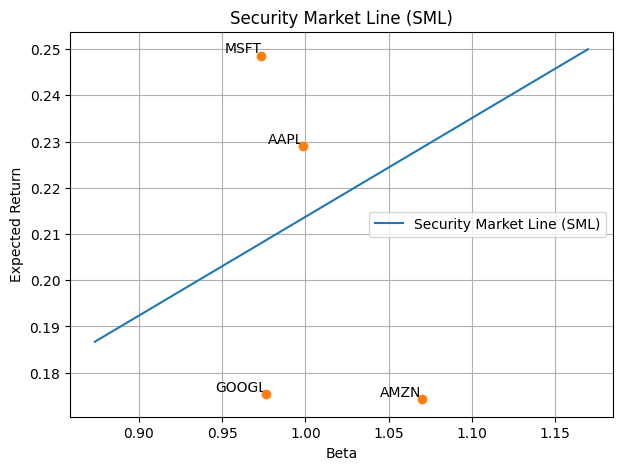

In [13]:
# Plot Security Market Line (SML) with historical mean returns
from src.implied_returns import asset_betas

# Compute betas for each asset
betas = asset_betas(Sigma_hist, w_mkt)

# SML: E[r_i] = r_f + beta_i * (E[r_m] - r_f)
rf = RISK_FREE if RISK_FREE is not None else 0.0
sml_x = np.linspace(betas.min() - 0.1, betas.max() + 0.1, 100)
sml_y = rf + sml_x * (mkt_return - rf)

plt.figure(figsize=(7,5))
plt.plot(sml_x, sml_y, label='Security Market Line (SML)', color='C0')
plt.scatter(betas, mu_hist, color='C1', zorder=5)
for ticker, beta, mu in zip(betas.index, betas, mu_hist):
    plt.text(beta, mu, ticker, fontsize=10, ha='right', va='bottom')
plt.xlabel('Beta')
plt.ylabel('Expected Return')
plt.title('Security Market Line (SML)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Views and BL posterior

In [6]:
# Example relative view: AAPL expected to outperform MSFT by 2% annually
P_row, q = vw.relative_view(TICKERS, long='AAPL', short='MSFT', magnitude=0.02)
P, Q = vw.build_PQ([(P_row, q)])
bl = opt.black_litterman_posterior(Sigma_hist, pi, P, Q, tau=TAU)
print('BL posterior mean:')
display(bl.mu_bl)

BL posterior mean:


AAPL     0.218085
MSFT     0.205409
GOOGL    0.208081
AMZN     0.228090
dtype: float64

# 6. Efficient frontiers and plot

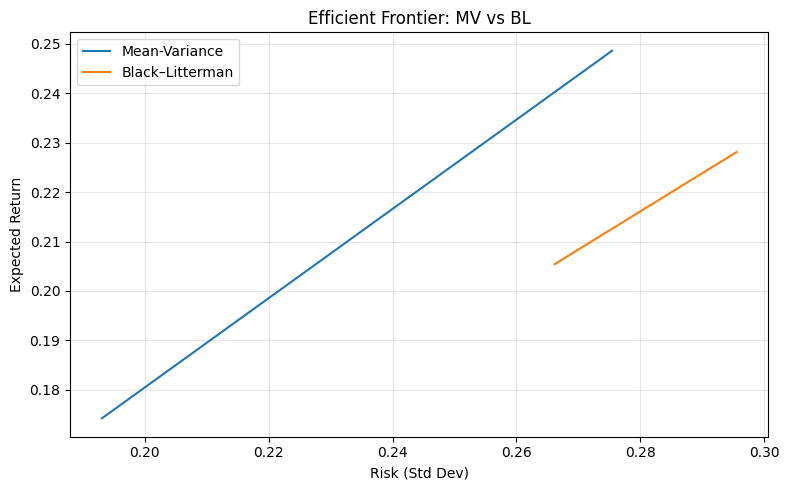

In [15]:
curves = opt.compare_mv_vs_bl(mu_hist, Sigma_hist, bl.mu_bl, bl.Sigma_bl, risk_free=RISK_FREE)
fig, ax = plots.plot_frontiers(*curves.values())
plt.show()

In [21]:
# Compare MV and BL optimal weights and stats at the midpoint of the BL (yellow) efficient frontier
mv_weights_list = curves['mv'][1]
bl_weights_list = curves['bl'][1]
bl_returns = curves['bl'][0]
mv_returns = curves['mv'][0]
mid = len(bl_weights_list) // 2

# Get BL midpoint weights and target return
bl_w = bl_weights_list[mid]
target_ret = float(bl_w @ bl.mu_bl)

# Compute MV weights for the same target return as BL midpoint
mv_w = opt._quad_solve_weights(mu_hist, Sigma_hist, target_return=target_ret)

# Compute stats
exp_ret_mv = float(mv_w @ mu_hist)
std_mv = float(np.sqrt(mv_w.values.T @ Sigma_hist.values @ mv_w.values))
exp_ret_bl = float(bl_w @ bl.mu_bl)
std_bl = float(np.sqrt(bl_w.values.T @ bl.Sigma_bl.values @ bl_w.values))

# Build table
print('Optimal portfolio allocation for MV and BL with a target return of', f'{target_ret:.4g}')
comparison_df = pd.DataFrame(
    [mv_w.values, bl_w.values],
    columns=mv_w.index, index=["MV", "BL"]
)
comparison_df.index.name = "Model"
comparison_df

Optimal portfolio allocation for MV and BL with a target return of 0.217


,AAPL,MSFT,GOOGL,AMZN
Model,,,,
MV,0.275590,0.826358,-0.132419,-0.162659
BL,0.335051,0.273683,0.203881,0.198478


#### MV Model
- Interpretation
    - Strong overweight in MSFT (83%) and moderate weight in AAPL (28%).
    Negative weights in GOOGL and AMZN mean short positions (selling those stocks, using proceeds to buy more MSFT/AAPL).

- Why this happens:
    - As can be seen from the SML plot, historically MSFT had high return with relatively low volatility. 
    - Since MV uses historical mean returns directly, the optimizer will push heavily into MSFT.

#### BL Model
- Interpretation
    - Much more balanced allocation: all positive weights, between ~20%–34%.

- Why this happens:
    - BL reflects the view that AAPL should outperform MSFT by 2% annually.


## 7. Tangent portfolios comparison

In [22]:
w_mv, r_mv, s_mv, sh_mv = opt.max_sharpe_portfolio(mu_hist, Sigma_hist, risk_free=RISK_FREE)
w_bl, r_bl, s_bl, sh_bl = opt.max_sharpe_portfolio(bl.mu_bl, bl.Sigma_bl, risk_free=RISK_FREE)

print('MV max Sharpe metrics:', {'ret': r_mv, 'risk': s_mv, 'sharpe': sh_mv})
print('BL max Sharpe metrics:', {'ret': r_bl, 'risk': s_bl, 'sharpe': sh_bl})

# Table: MV and BL tangent (max Sharpe) portfolio weights
if w_mv is not None and w_bl is not None:
    tangent_df = pd.DataFrame([w_mv.values, w_bl.values], columns=w_mv.index, index=["MV", "BL"])
    tangent_df.index.name = "Model"
    print('Tangent (max Sharpe) portfolio weights:')
    display(tangent_df)
else:
    print("Tangent (max Sharpe) portfolio is undefined for at least one model.")

MV max Sharpe metrics: {'ret': 0.268916943464562, 'risk': 0.29795722354204546, 'sharpe': 0.9025354051391609}
BL max Sharpe metrics: {'ret': 0.21460055239415066, 'risk': 0.2780485302722114, 'sharpe': 0.7718096987719499}
Tangent (max Sharpe) portfolio weights:


,AAPL,MSFT,GOOGL,AMZN
Model,,,,
MV,0.341555,1.024152,-0.164115,-0.201592
BL,0.331375,0.270680,0.201644,0.196300
